In [125]:
# -----------------------------------------------------------------*
# SEIS 764 Artificial Intelligence
# Assignment 4 : Convolution Neural Networks
# auther: Yann Mulonda - October 20, 2021
# -----------------------------------------------------------------*
# Import the libraries needed
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model 
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import (Input, Conv2D, Dense, Flatten, 
                                     Dropout, GlobalMaxPooling2D, 
                                     MaxPooling2D, 
                                     BatchNormalization)

In [126]:
# -----------------------------------------------------------------*
# Convolutional Neural Network for classifying 
# Fashion-MNIST dataset using of the Keras functional API. 
# The functional API is a much cleaner way of writing the code and 
# allows you to create complex networks with shared layers as well.
# -----------------------------------------------------------------*

In [ ]:
# load the data by calling the load_data() function which returns
# 2 tuples -- training and test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# keep an non pre-processed copy of X_test/y_test for visualization
test_images, test_labels = x_test.copy(), y_test.copy()

In [128]:
# function to display or plot result
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction (if it matches
        actual)
        or actual/prediction if there is a mismatch
    """
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap="Greys")

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % FASHION_LABELS[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = FASHION_LABELS[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[true_label], FASHION_LABELS[pred_label])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

In [129]:
# using the display_sample() function above
# let's define a function that plot result
def showResult(plot_title, x_test, test_images, test_labels, y_pred=None):
  sample_size = 50
  rand_indexes = np.random.randint(0, len(x_test), sample_size)
  sample_images = test_images[rand_indexes]
  sample_labels = test_labels[rand_indexes]

  if y_pred is None:
    display_sample(sample_images,
                   sample_labels, 
                   plot_title=plot_title % sample_size)
  else:
    sample_predictions = np.argmax(y_pred[rand_indexes], axis=1)

    display_sample(sample_images,
                   sample_labels, 
                   sample_predictions,
                   num_rows=5, 
                   num_cols=10, 
                   plot_title=plot_title % sample_size)

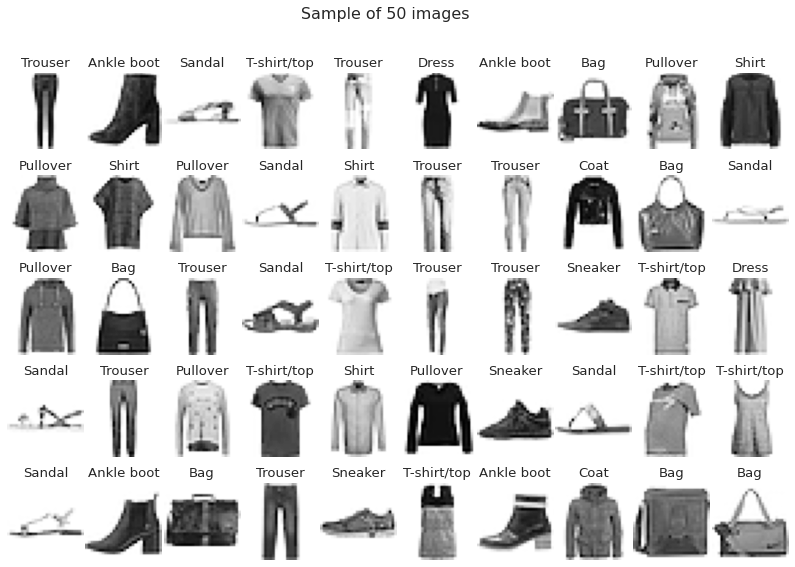

In [130]:
# le's do some data visualisation and displays 50 images from the test dataset
showResult('Sample of %d images', x_test, test_images, test_labels)

In [131]:
# let's normalize the data dimensions so that they are 
# of approximately the same scale
x_train, x_test = x_train / 255.0, x_test / 255.0
print("x_train.shape:", x_train.shape)

x_train.shape: (60000, 28, 28)


In [132]:
# We can see that the shape returned is (60000,28,28) 
# Convolution expects data to be in HxWxC format where C is number of channels.
# So let's convert the data to be of the form (28,28,1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)

(60000, 28, 28, 1)


In [133]:
# To verify the number of class labels, we cast y_train as a set and print its 
# length
# K -- number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


In [134]:
# -----------------------------------------------------------------*
# Now let's Build the model using the functional API
def functionalAPIModel(numberOfConvo=None, numOfStrides=None, use_dropout=False, bestModel=False):
  i = Input(shape=x_train[0].shape)

  if numberOfConvo is '1':
    print('CNN Model with one convo and %s strides'%(numOfStrides))
    if numOfStrides is None:
      x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
      if bestModel: x = BatchNormalization()(x)
    else:
      x = Conv2D(32, (3, 3), strides=numOfStrides, activation='relu', padding='same')(i)
      if bestModel: x = BatchNormalization()(x)

    x = Flatten()(x)
    if use_dropout: 
      print('---and Dropout---')
      x = Dropout(0.15)(x)
    x = Dense(512, activation='relu')(x)
    if use_dropout: x = Dropout(0.15)(x)
    x = Dense(K, activation='softmax')(x)
    
  elif numberOfConvo is '2':
    print('CNN Model with two convos and %s strides'%(numOfStrides))
    if numOfStrides is None:
      x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
      if bestModel: x = BatchNormalization()(x)
      x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
      if bestModel: x = BatchNormalization()(x)
    else:
      x = Conv2D(32, (3, 3), strides=numOfStrides, activation='relu', padding='same')(i)
      if bestModel: x = BatchNormalization()(x)
      x = Conv2D(64, (3, 3), strides=numOfStrides, activation='relu', padding='same')(x)
      if bestModel: x = BatchNormalization()(x)

    x = Flatten()(x)
    if use_dropout: 
      print('---and Dropout---')
      x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    if use_dropout: x = Dropout(0.2)(x)
    x = Dense(K, activation='softmax')(x)

  else:
    print('CNN Model with three convos and %s strides'%(numOfStrides))
    if numOfStrides is None:
      x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
      if bestModel: x = BatchNormalization()(x)
      x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
      if bestModel: x = BatchNormalization()(x)
      x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
      if bestModel: x = BatchNormalization()(x)
    else:
      x = Conv2D(32, (3, 3), strides=numOfStrides, activation='relu', padding='same')(i)
      if bestModel: x = BatchNormalization()(x)
      x = Conv2D(64, (3, 3), strides=numOfStrides, activation='relu', padding='same')(x)
      if bestModel: x = BatchNormalization()(x)
      x = Conv2D(128, (3, 3), strides=numOfStrides, activation='relu', padding='same')(x)
      if bestModel: x = BatchNormalization()(x)

    x = Flatten()(x)
    if use_dropout: 
      print('---and Dropout---')
      x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    if use_dropout: x = Dropout(0.3)(x)
    x = Dense(K, activation='softmax')(x)

  model = Model(i, x)
  return model

# -----------------------------------------------------------------*
# Compiling and fitting the model
def compilingAndFitting(model, x_train, y_train, x_test, y_test):
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  # train the model
  r = model.fit(x_train,
                y_train,
                validation_data=(x_test, y_test),
                epochs=15,
                verbose=0)
  return r

# -----------------------------------------------------------------*
# Ploting loss and Accuracy per iteration
def plotLoss(r):
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.title('Loss per iteration')
  plt.legend()

def plotAccuracy(r):
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.title('Accuracy per iteration')
  plt.legend()
  
# -----------------------------------------------------------------*
#Confusion Matrix
def confusionMatrix(model, x_test, y_test):
  y_pred = model.predict(x_test).argmax(axis=1)
  cm = confusion_matrix(y_test,y_pred)
  print("               Predicted Label")
  print(cm)

# -----------------------------------------------------------------*
# Let's see the test result of 50 random images
def predictAndtest(model, x_test, test_images, test_labels):
  # run predictions
  y_pred = model.predict(x_test)
  # plot result
  showResult('Model Test result of %d images',
            x_test, test_images, test_labels, y_pred)
  
# -----------------------------------------------------------------*
# Evaluate the model on test set 
def evaluateModel(model, x_test, y_test):
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  # Print test accuracy and loss
  print('Model Evaluation *---* Loss %.3f and Accuracy %.3f' % (loss, acc))

In [135]:
# model summary is shown by the following
model = functionalAPIModel()
# model.summary()

CNN Model with three convos and None strides


In [136]:
# -----------------------------------------------------------------*
# Conv-Pool: 
# Model 1: Build the first CNN with one conv-pool 
# (i.e. convolution followed by max pooling)
# -----------------------------------------------------------------*
model1 = functionalAPIModel('1')
model1.summary()

CNN Model with one convo and None strides
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
flatten_40 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_80 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dense_81 (Dense)             (None, 10)                5130      
Total params: 12,851,018
Trainable params: 12,851,018
Non-trainable params: 0
_________________________________________________________________


In [137]:
# get the training result
r1 = compilingAndFitting(model1, x_train, y_train, x_test, y_test)

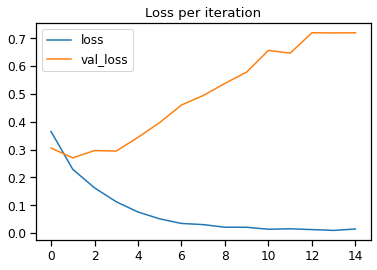

In [138]:
# Plot loss per iteration for the initial model
plotLoss(r1)

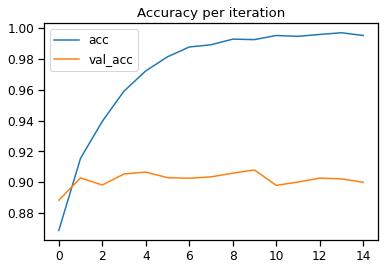

In [139]:
# Plot accuracy per iteration for the initial model
plotAccuracy(r1)

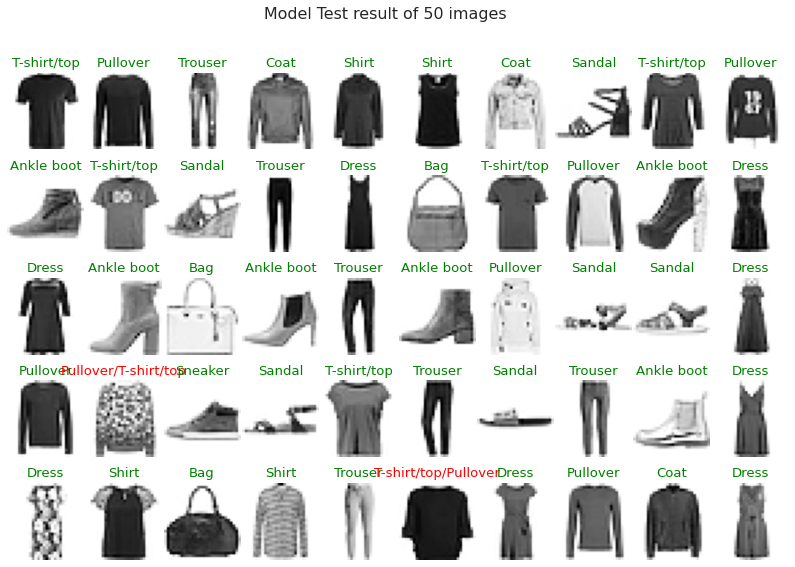

In [140]:
# show model sample test result
# **Green is correct prediction
# **Red is incorrect prediction
predictAndtest(model1, x_test, test_images, test_labels)

In [141]:
# evaluate the model
evaluateModel(model1, x_test, y_test)

Model Evaluation *---* Loss 0.720 and Accuracy 0.900


In [142]:
# -----------------------------------------------------------------*
# Model 2: In this model, have two conv-pools
# -----------------------------------------------------------------*
model2 = functionalAPIModel('2')
model2.summary()

CNN Model with two convos and None strides
Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
flatten_41 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_82 (Dense)             (None, 512)               25690624  
_________________________________________________________________
dense_83 (Dense)             (None, 10)                5130      
Total params: 25,714,570
Trainable params: 25,714,570
Non-trainable params: 0
___

In [143]:
# get the training result
r2 = compilingAndFitting(model2, x_train, y_train, x_test, y_test)

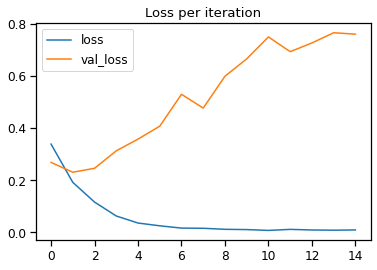

In [144]:
# Plot loss per iteration for the initial model
plotLoss(r2)

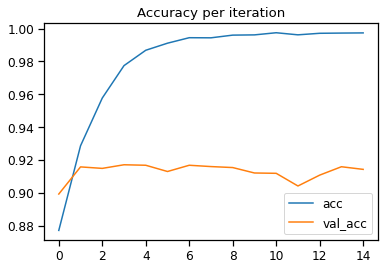

In [145]:
# Plot accuracy per iteration for the initial model
plotAccuracy(r2)

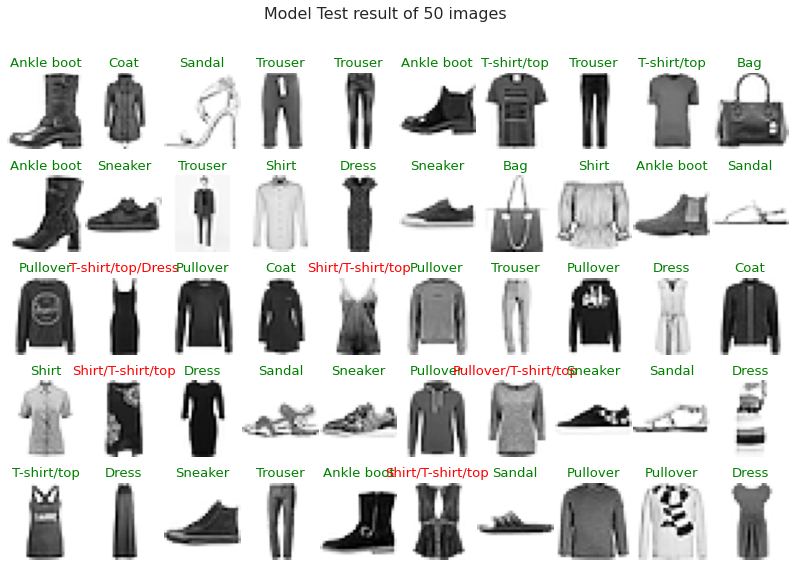

In [146]:
# show model sample test result
# **Green is correct prediction
# **Red is incorrect prediction
predictAndtest(model2, x_test, test_images, test_labels)

In [147]:
# evaluate the model
evaluateModel(model2, x_test, y_test)

Model Evaluation *---* Loss 0.760 and Accuracy 0.914


In [148]:
# -----------------------------------------------------------------* 
# Model 3: Try different model optimization strategies like Dropout, 
# increasing the number of conv-pooling layers, etc.
# -----------------------------------------------------------------*
model3 = functionalAPIModel()
model3.summary()

CNN Model with three convos and None strides
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
flatten_42 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_84 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dense_85 (Den

In [149]:
# get the training result
r3 = compilingAndFitting(model3, x_train, y_train, x_test, y_test)

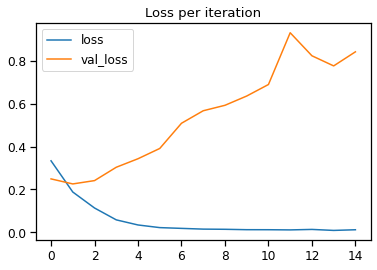

In [150]:
# Plot loss per iteration for the initial model
plotLoss(r3)

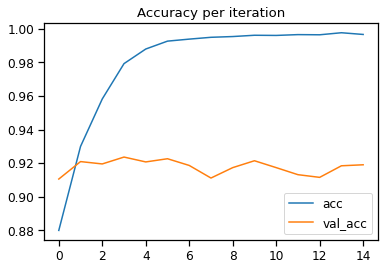

In [151]:
# Plot accuracy per iteration for the initial model
plotAccuracy(r3)

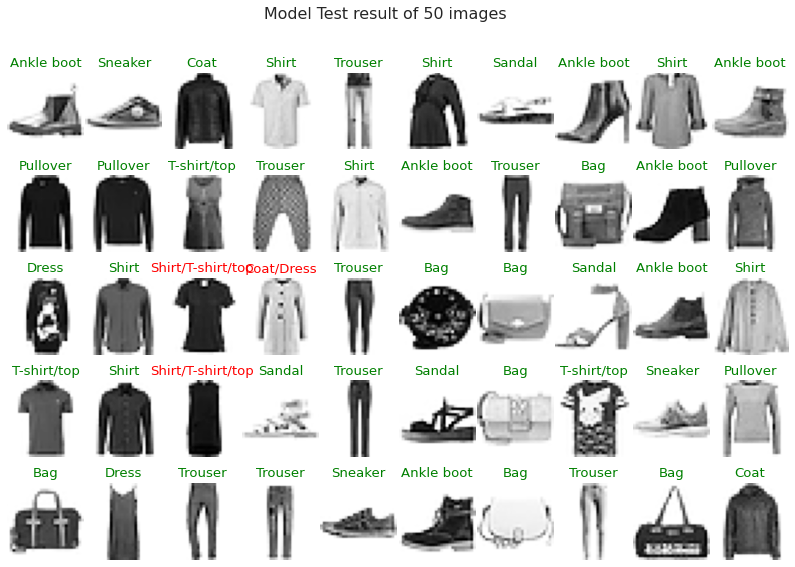

In [152]:
# show model sample test result
# **Green is correct prediction
# **Red is incorrect prediction
predictAndtest(model3, x_test, test_images, test_labels)

In [153]:
# evaluate the model
evaluateModel(model3, x_test, y_test)

Model Evaluation *---* Loss 0.842 and Accuracy 0.919


In [154]:
# Model 1: with Dropout
model1_d = functionalAPIModel('1', use_dropout=True)
r1_d = compilingAndFitting(model1_d, x_train, y_train, x_test, y_test)
# evaluate the model
evaluateModel(model1_d, x_test, y_test)

CNN Model with one convo and None strides
---and Dropout---
Model Evaluation *---* Loss 0.582 and Accuracy 0.905


In [155]:
# Model 2: with Dropout
model2_d = functionalAPIModel('2', use_dropout=True)
r2_d = compilingAndFitting(model2_d, x_train, y_train, x_test, y_test)
# evaluate the model
evaluateModel(model2_d, x_test, y_test)

CNN Model with two convos and None strides
---and Dropout---
Model Evaluation *---* Loss 0.620 and Accuracy 0.918


In [156]:
# Model 3: with Dropout
model3_d = functionalAPIModel(use_dropout=True)
r3_d = compilingAndFitting(model3_d, x_train, y_train, x_test, y_test)
# evaluate the model
evaluateModel(model3_d, x_test, y_test)

CNN Model with three convos and None strides
---and Dropout---
Model Evaluation *---* Loss 0.612 and Accuracy 0.924


In [157]:
# -----------------------------------------------------------------*
# Strided Conv:
# Model 4: Build a CNN with one strided convolution layer.
# -----------------------------------------------------------------*
model4 = functionalAPIModel('1', numOfStrides=1)
r4 = compilingAndFitting(model4, x_train, y_train, x_test, y_test)
# evaluate the model
evaluateModel(model4, x_test, y_test)

CNN Model with one convo and 1 strides
Model Evaluation *---* Loss 0.695 and Accuracy 0.902


In [158]:
# -----------------------------------------------------------------*
# Strided Conv:
# Model 5: Build a CNN with two strided convolution layers
# -----------------------------------------------------------------*
model5 = functionalAPIModel('2', numOfStrides=2)
r5 = compilingAndFitting(model5, x_train, y_train, x_test, y_test)
# evaluate the model
evaluateModel(model5, x_test, y_test)

CNN Model with two convos and 2 strides
Model Evaluation *---* Loss 0.648 and Accuracy 0.911


In [159]:
# -----------------------------------------------------------------*
# Strided Conv:
# Model 6: Try different model optimization strategies like Dropout, 
# increasing the number of strided conv layers, etc.
# -----------------------------------------------------------------*
model6 = functionalAPIModel(numOfStrides=2, use_dropout=True)
r65 = compilingAndFitting(model6, x_train, y_train, x_test, y_test)
# evaluate the model
evaluateModel(model6, x_test, y_test)

CNN Model with three convos and 2 strides
---and Dropout---
Model Evaluation *---* Loss 0.292 and Accuracy 0.916


In [160]:
# -----------------------------------------------------------------*
# Image Data Augmentation:  
# Model 7: Of the 6 models, take the best model you have, 
# and perform Batch Normalization.
# -----------------------------------------------------------------*
model7 = functionalAPIModel(numOfStrides=2, use_dropout=True, bestModel=True)
r7 = compilingAndFitting(model7, x_train, y_train, x_test, y_test)
# evaluate the model
evaluateModel(model7, x_test, y_test)

CNN Model with three convos and 2 strides
---and Dropout---
Model Evaluation *---* Loss 0.300 and Accuracy 0.918
